# How to run the simulator
$ python drive.py model.h5

In [1]:
data_dir = "../../../DATA/behavioral_cloning_data/"
processed_images_dir = "processed_images_64/"
model_dir = "../../../DATA/MODELS/"
model_name = "model_p3_keras_tf_mini_14x64x3__epoch_30_val_acc_0.335463257167.h5"
image_final_width = 64
model_path = model_dir + model_name
autorun_dir = data_dir + "autonomous_run/"
sample_autorun_image = "image_10.302895069122314.jpg"

In [2]:
import argparse
import base64
import json
import numpy as np
import time
import eventlet
import eventlet.wsgi
import tensorflow as tf
import socketio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
from PIL import ImageOps
from flask import Flask, render_template
from io import BytesIO
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array

# if says Using Theano backend.
# $ edit ~/.keras/keras.json
# change to: "backend": "tensorflow",

Using TensorFlow backend.


In [3]:
# https://github.com/fchollet/keras/issues/3857
tf.python.control_flow_ops = tf

In [4]:
from DataHelper import create_steering_classes
steering_classes = create_steering_classes(number_of_classes = 41)

In [5]:
def load_and_compile_model():
    from keras.models import load_model
    model = load_model(model_path) # should start at 60% acc.
   
    optimizer='sgd' # | 'rmsprop'
    loss_function="mse" # | 'binary_crossentropy' | 'mse' | mean_squared_error | sparse_categorical_crossentropy
    metrics_array=['accuracy'] # , mean_pred, false_rates

    model.compile(optimizer, loss_function, metrics_array)
    return model
    

# Test model loading

In [6]:
model = load_and_compile_model()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 14, 64, 64)    1792        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 64, 128)   73856       convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 14, 64, 256)   295168      convolution2d_2[0][0]            
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 229376)        0           convolution2d_3[0][0]            
___________________________________________________________________________________________

# Test prediction

In [7]:
def predict_steering(image, old_steering):
    image = np.array(image)
    image = image[None, :, :] # string indices must be integers
    predictions = model.predict(image)
    prediction = float(predictions[0][0])
    
    #print("predictions", predictions)
    most_likely = np.argmax(predictions)
    #print("most_likely", most_likely)
    new_steering_angle = steering_classes[most_likely]
    #print("new_steering_angle", new_steering_angle)
    return new_steering_angle 

image shape (14, 64, 3)


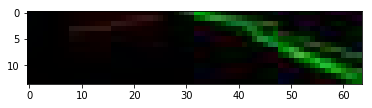

new_steering_angle -0.05


In [8]:
from DataHelper import load_image
image_path = autorun_dir + sample_autorun_image
image = np.array(load_image(image_path))
print("image shape", image.shape)
plt.imshow(image)
plt.show()

new_steering_angle = predict_steering(image, 0.0)
print("new_steering_angle", new_steering_angle)

In [9]:
def preprocess_image(image_string, elapsed_seconds):   
    
    from scipy.misc import imsave
    from ImageHelper import preprocessing_pipline
    
    image_jpg = Image.open(BytesIO(base64.b64decode(image_string)))
    image_array = preprocessing_pipline(image_jpg, final_size=image_final_width, should_plot=False)
    
    # SAVE ONLY to review that pre-processing worked
    # imsave(data_dir + "autonomous_run/image_" + str(elapsed_seconds) + ".jpg", image_array)
    return image_array

In [10]:
sio = socketio.Server()
app = Flask(__name__)
model = None
prev_image_array = None

In [11]:
t0 = time.time()

@sio.on('telemetry')
def telemetry(sid, data):
    with open("output.txt", "a") as myfile:
        elapsed_seconds = time.time()-t0
        
        # The current steering angle of the car
        steering_angle = data["steering_angle"]
        
        # The current throttle of the car
        throttle = data["throttle"]
        
        # The current speed of the car
        speed = data["speed"]

        # The current image from the center camera of the car
        image = preprocess_image(data["image"], elapsed_seconds)

        new_steering_angle = predict_steering(image, steering_angle)
        new_throttle = 0.3
        
        output = []
        output.append(str(round(float(elapsed_seconds),2)) + "\t")
        output.append(str(round(float(speed),2)) + "\t")
        output.append(str(round(float(steering_angle),2)) +"->")
        output.append(str(round(float(new_steering_angle),2)) +"\t" )
        output.append(str(round(float(throttle),2)) +"->" )
        output.append(str(round(float(new_throttle),2)) + "\n" )
        output_text = ''.join(output)
        myfile.write(output_text)
        #print(output_text)
        
        send_control(new_steering_angle, new_throttle)

# $ tail -f ~/dev/carnd/p3_behavioral_cloning/behavioral_cloning_UkiDLucas/output.txt 

In [12]:
@sio.on('connect')
def connect(sid, environ):
    print("connect ", sid)
    send_control(0, 0)

In [ ]:
def send_control(steering_angle=0.0, throttle=0.2):
    sio.emit("steer", data={
    'steering_angle': steering_angle.__str__(),
    'throttle': throttle.__str__()
    }, skip_sid=True)

In [ ]:
if __name__ == '__main__':
    #parser = argparse.ArgumentParser(description='Remote Driving')
    #parser.add_argument('model', type=str,
    #help='Path to model definition h5. Model should be on the same path.')
    #args = parser.parse_args()

    #model = load_model(args.model)
    model = load_and_compile_model()
    
    
    # wrap Flask application with engineio's middleware
    app = socketio.Middleware(sio, app)

    # deploy as an eventlet WSGI server
    eventlet.wsgi.server(eventlet.listen(('', 4567)), app)

(93233) wsgi starting up on http://0.0.0.0:4567
(93233) accepted ('127.0.0.1', 54276)


connect  1854c4cbc1b34696b2c82a14fa235e0f


/Users/ukilucas/dev/carnd/p3_behavioral_cloning/p3_UkiDLucas/ImageHelper.py:284: RuntimeWarning: divide by zero encountered in int_scalars
  slope = rise/run
